In [ ]:
!pip3 install numpyro
!pip3 install -U pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.tsa.stattools import adfuller
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)

assert numpyro.__version__.startswith("0.10.1")

In [ ]:
def load_data(path):
    extension=path.split(".")[1]
    
    df=None
    
    if(extension=="csv"):
        df=pd.read_csv(path)
        
    if(extension=="json"):
        df=pd.read_json(path)
        
    if(extension=="xlsx"):
        df=pd.read_excel(path)
        
    if(extension=="sql"):
        df=pd.read_sql(path)

    return df

In [ ]:
def data_values(path_data):
  lynx = load_data(path_data)
  data = pd.DataFrame(lynx["value"])
  return data;

In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean =  timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).mean()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
def test_stationarity_noprint(timeseries):
    
    #Determing rolling statistics
    rolmean =  timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).mean()

    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, maxlag=1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dftest

In [ ]:
def is_statitonary(values,percentage,varbose):
  result = test_stationarity_noprint(values)
  #print(result)
  if (result[0] < result[4][percentage]):
    if(varbose==1):
      print("Time Series is Stationary")
    return 1
  else:
    if(varbose==1):
      print("Time Series is Non-Stationary")
    return 0   

In [ ]:
def transform_method(df, method):
  if method=="sqrt":
    df_res=np.sqrt(df)
  elif method=="log":
    df_res=np.log(df)
  else:
    return "wrong input"

  return df_res

In [ ]:
def make_stationary(values,sig_level,method,verbose):
  c=0
  x=values
  percent=sig_level
  result = test_stationarity_noprint(x)
  while  result[0] > result[4][percent] and c<3:
    c=c+1
    x=transform_method(x,method)
    result=test_stationarity_noprint(x)

  if result[0] < result[4]["10%"]:
    if(verbose):
      print ("Time Series is Stationary")
    return 1,x
  else:
    if(verbose):
      print ("Time Series is Non-Stationary after 3 transformations")
    return 0,x

In [ ]:
def test_split(stat_data,split):
  temp = stat_data["value"].to_numpy()
  y_train, y_test = jnp.array(temp[:split], dtype=jnp.float32), temp[split:]
  return y_train,y_test


In [ ]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [ ]:
def train_model(split_data,num_warmup1=5000,num_samples1=5000,num_chains1=4,seasonality1=38):
  kernel = NUTS(sgt)
  #mcmc = MCMC(kernel, num_warmup, num_samples, num_chains)
  mcmc = MCMC(kernel, num_warmup=num_warmup1, num_samples=num_samples1, num_chains=num_chains1)

  mcmc.run(random.PRNGKey(0), split_data, seasonality = seasonality1)
  mcmc.print_summary()
  samples = mcmc.get_samples()
  return samples

In [ ]:
def get_forecast(values):
  predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
  forecast_marginal = predictive(random.PRNGKey(1),values[0], seasonality=38, future=34)["y_forecast"]
  return forecast_marginal


In [ ]:
def get_pred_values(forecast_marginal):
  y_pred = jnp.mean(forecast_marginal, axis=0)
  sMAPE = jnp.mean(jnp.abs(y_pred - statitonary_split_values[1]) / (y_pred + statitonary_split_values[1])) * 200
  msqrt = jnp.sqrt(jnp.mean((y_pred - statitonary_split_values[1]) ** 2))
  print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt)) 
  return y_pred

In [ ]:
def plot_graph(dataset,y_pred,forecast_marginal):
  plt.figure(figsize=(8, 4))
  plt.plot(dataset["time"], lynx_values.to_numpy())
  t_future = dataset["time"][80:]
  hpd_low, hpd_high = hpdi(forecast_marginal)
  plt.plot(t_future, y_pred, lw=2)
  plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
  plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
  plt.show()

<h1> user code - 

In [ ]:
lynx1 = load_data("/content/lynx2.csv")

In [ ]:
lynx1

,time,value
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475
...,...,...
109,1930,662
110,1931,1000
111,1932,1590
112,1933,2657


In [ ]:
lynx_values = data_values("/content/lynx2.csv")

In [ ]:
stationary_values = make_stationary(lynx_values,"5%","sqrt",1)

Time Series is Stationary


In [ ]:
stationary_values[1]

,value
0,269
1,321
2,585
3,871
4,1475
...,...
109,662
110,1000
111,1590
112,2657


In [ ]:
is_statitonary(stationary_values[1],"5%",1)

Time Series is Stationary


1

In [ ]:
statitonary_split_values = test_split(stationary_values[1],80)

In [ ]:
statitonary_split_values[1]

array([ 758, 1307, 3465, 6991, 6313, 3794, 1836,  345,  382,  808, 1388,
       2713, 3800, 3091, 2985, 3790,  674,   81,   80,  108,  229,  399,
       1132, 2432, 3574, 2935, 1537,  529,  485,  662, 1000, 1590, 2657,
       3396])

In [ ]:
samples = train_model(statitonary_split_values[0],5000,5000,4,38)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     34.93    126.54     14.07    -91.46    166.93   1972.22      1.00
       init_s[0]     85.18    106.23     66.03    -61.98    237.49   4645.74      1.00
       init_s[1]    -19.62     71.70    -24.14   -128.70     90.07   5755.90      1.00
       init_s[2]     29.64     92.37     17.68   -112.96    170.43   6310.70      1.00
       init_s[3]    124.53    127.49    105.81    -72.92    305.54   5544.35      1.00
       init_s[4]    450.22    262.74    401.47     75.72    823.79   4029.61      1.00
       init_s[5]   1181.59    474.81   1102.10    476.14   1884.22   2799.72      1.00
       init_s[6]   2003.82    683.89   1894.95    981.16   3026.42   2326.26      1.00
       init_s[7]   3681.61   1116.49   3536.70   2039.27   5442.78   1721.85      1.00
       init_s[8]   2609.41    837.91   2497.66   1328.49   3881.22   1799.94      1.00
       init_s[9]    958.74    442.88    88

In [ ]:
forecast_marginal = get_forecast(statitonary_split_values)

In [ ]:
y_pred = get_pred_values(forecast_marginal)

sMAPE: 64.07, rmse: 1251.02


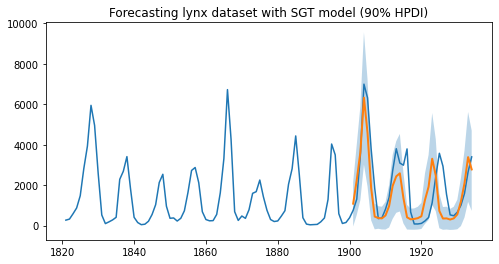

In [ ]:
plot_graph(lynx1,y_pred,forecast_marginal)